In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import unicodedata
import re
import json

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

import pandas as pd

import acquire
import prepare
import env

# 1. Spam Data

#### 1a. load the spam dataset

In [2]:
url = env.get_db_url('spam_db')
sql = 'SELECT * FROM spam'
df = pd.read_sql(sql, url, index_col='id')
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
ham_words = prepare.basic_clean(' '.join(df[df.label == 'ham'].text))
ham_words = prepare.tokenize(ham_words)
ham_words = prepare.remove_stopwords(ham_words)
ham_words = prepare.lemmatize(ham_words)

spam_words = prepare.basic_clean(' '.join(df[df.label == 'spam'].text))
spam_words = prepare.tokenize(spam_words)
ham_words = prepare.remove_stopwords(ham_words)
spam_words = prepare.lemmatize(spam_words)

all_words = ham_words + spam_words

#### 1b. Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams

In [4]:
ham_bis = list(nltk.ngrams(ham_words.split(), 2))
spam_bis = list(nltk.ngrams(spam_words.split(), 2))
all_bis = list(nltk.ngrams(all_words.split(), 2))

In [5]:
ham_bi_counts = pd.concat([pd.Series(ham_bis).value_counts()])
spam_bi_counts = pd.concat([pd.Series(spam_bis).value_counts()])
all_bi_counts = pd.concat([pd.Series(all_bis).value_counts()])

bi_counts = (pd.concat([ham_bi_counts, spam_bi_counts, all_bi_counts], axis=1)
               .set_axis(['ham', 'spam', 'all'], axis=1, inplace=False) 
             .fillna(0).apply(lambda s: s.astype(int)).sort_values(by='all', ascending=False))
bi_counts

,,ham,spam,all
you,have,0,73,73
',s,0,67,67
have,won,0,54,54
please,call,9,44,53
sorry,',52,0,52
...,...,...,...,...
resume,gd,1,0,1
luck,4,1,0,1
exam,u,1,0,1
true,namefree,0,0,1


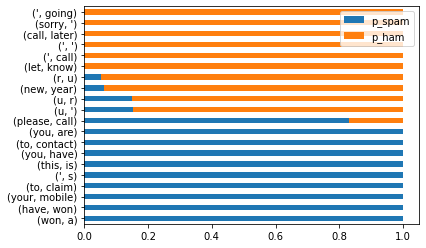

In [6]:
(bi_counts
 .assign(p_spam=bi_counts.spam / bi_counts['all'],
         p_ham=bi_counts.ham / bi_counts['all'])
 .sort_values(by='all')
 [['p_spam', 'p_ham']]
 .tail(20)
 .sort_values('p_ham')
 .plot.barh(stacked=True))
plt.show()

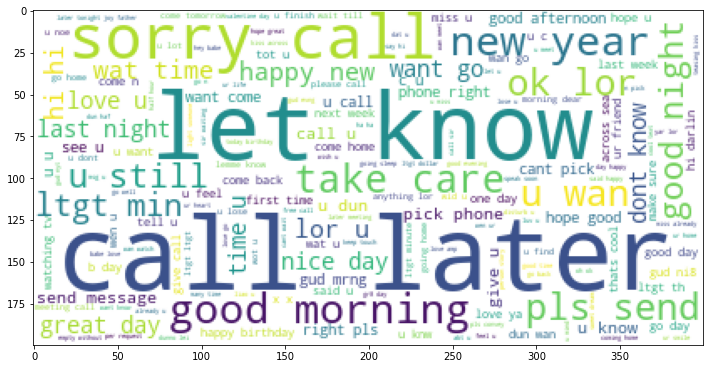

In [7]:
# ham bigrams
plt.figure(figsize=(12,8))
img = WordCloud(background_color='white',
                collocation_threshold = 3).generate(ham_words)
plt.imshow(img)
plt.show()

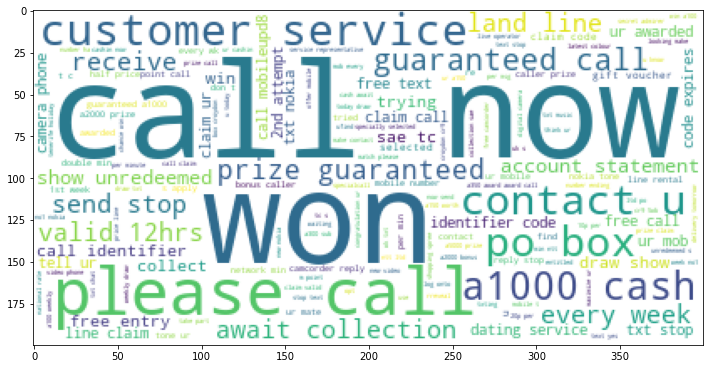

In [8]:
# spam bigrams
plt.figure(figsize=(12,8))
img = WordCloud(background_color='white',
                collocation_threshold = 3).generate(spam_words)
plt.imshow(img)
plt.show()

#### 1c. Is there any overlap in the bigrams for the spam data and the ham data?

In [9]:
intersection = set(ham_bis).intersection(set(spam_bis))

In [10]:
intersection_counts = bi_counts[bi_counts.index.isin(intersection)]

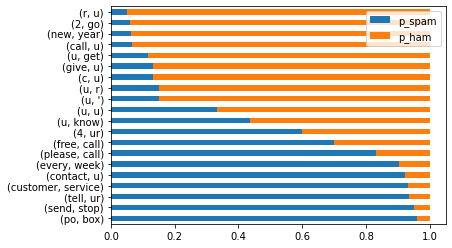

In [11]:
(intersection_counts
 .assign(p_spam=bi_counts.spam / intersection_counts['all'],
         p_ham=bi_counts.ham / intersection_counts['all'])
 .sort_values(by='all')
 [['p_spam', 'p_ham']]
 .tail(20)
 .sort_values('p_ham')
 .plot.barh(stacked=True))
plt.show()

#### 1d. Create and explore trigrams for both the spam  and ham data.

In [12]:
ham_tris = list(nltk.ngrams(ham_words.split(), 3))
spam_tris = list(nltk.ngrams(spam_words.split(), 3))
all_tris = list(nltk.ngrams(all_words.split(), 3))

ham_tris = ['_'.join(tri) for tri in ham_tris]
spam_tris = ['_'.join(tri) for tri in spam_tris]
all_tris = ['_'.join(tri) for tri in all_tris]

In [13]:
ham_tri_counts = pd.concat([pd.Series(ham_tris).value_counts()])
spam_tri_counts = pd.concat([pd.Series(spam_tris).value_counts()])
all_tri_counts = pd.concat([pd.Series(all_tris).value_counts()])

tri_counts = (pd.concat([ham_tri_counts, spam_tri_counts, all_tri_counts], axis=1)
               .set_axis(['ham', 'spam', 'all'], axis=1, inplace=False) 
             .fillna(0).apply(lambda s: s.astype(int)).sort_values(by='all', ascending=False))
tri_counts

,ham,spam,all
'_call_later,41,0,41
sorry_'_call,38,0,38
you_have_won,0,37,37
have_won_a,0,35,35
u_wan_2,21,0,21
...,...,...,...
going_robinson_already,1,0,1
robinson_already_ok,1,0,1
already_ok_set,1,0,1
namefree_entry_in,0,0,1


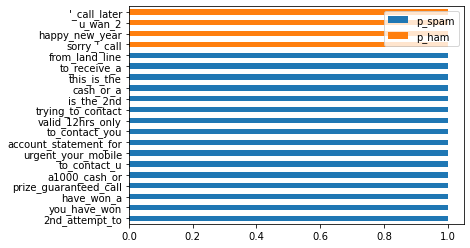

In [14]:
(tri_counts
 .assign(p_spam=tri_counts.spam / tri_counts['all'],
         p_ham=tri_counts.ham / tri_counts['all'])
 .sort_values(by='all')
 [['p_spam', 'p_ham']]
 .tail(20)
 .sort_values('p_ham')
 .plot.barh(stacked=True))
plt.show()

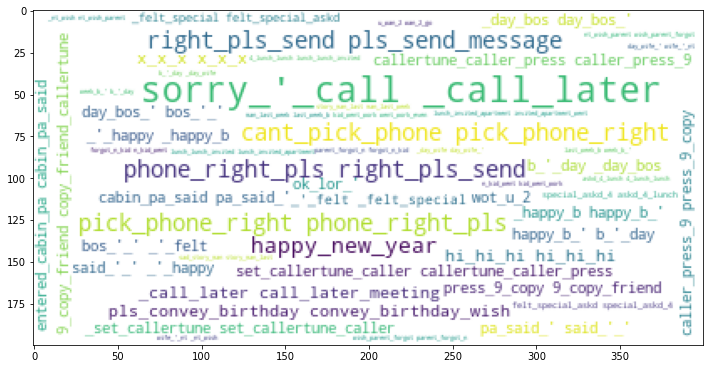

In [15]:
# ham_tris
plt.figure(figsize=(12,8))
img = WordCloud(background_color='white').generate(' '.join(ham_tris))
plt.imshow(img)
plt.show()

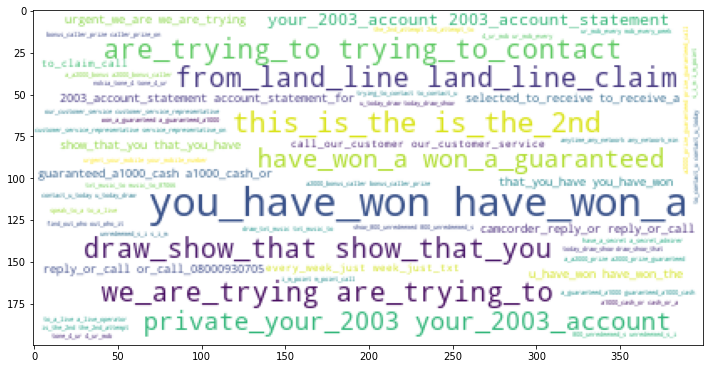

In [16]:
# spam_tris
plt.figure(figsize=(12,8))
img = WordCloud(background_color='white').generate(' '.join(spam_tris))
plt.imshow(img)
plt.show()

# 2. Blog Articles

In [17]:
df = acquire.get_blog_articles()
df = prepare.nlp_prep(df)
blog_words = ' '.join(df.clean)

Reading from local CSV...


In [18]:
blog_freq = pd.Series([word for word in blog_words.split()]).value_counts()
blog_freq.head(10)

codeup      874
data        731
career      439
job         391
get         352
science     351
like        347
tech        339
learn       317
students    298
dtype: int64

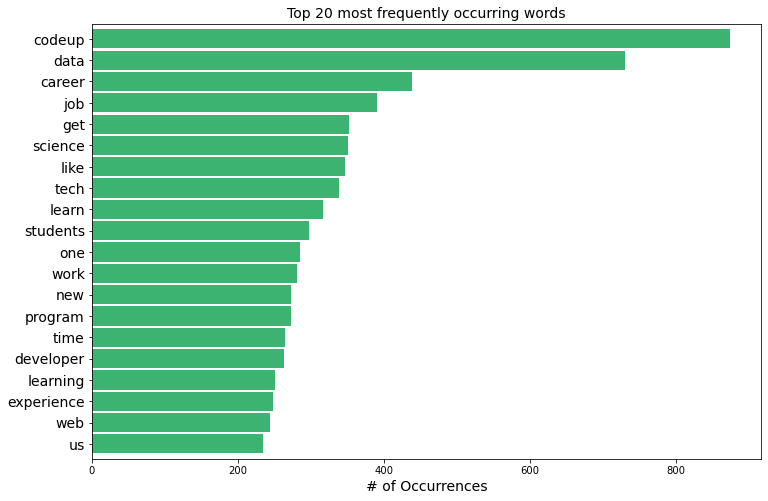

In [19]:
top_20_words = blog_freq.head(20)
top_20_words.sort_values().plot.barh(color='mediumseagreen', 
                                     width=.9, 
                                     figsize=(12,8))
plt.title('Top 20 most frequently occurring words', fontsize=14)
plt.xlabel('# of Occurrences', fontsize=14)
plt.yticks(fontsize=14)
plt.show()

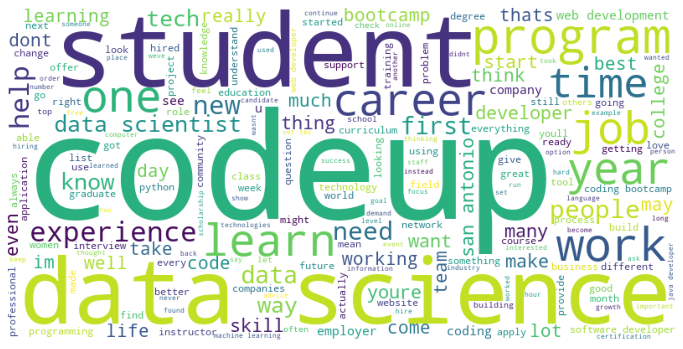

In [20]:
img = WordCloud(background_color='white', width=800, height=400).generate(blog_words)
plt.figure(figsize=(12,8))
plt.imshow(img)
plt.axis('off')
plt.show()

In [21]:
bigrams = list(nltk.ngrams(blog_words.split(), 2))
bigrams = ['_'.join(bi) for bi in bigrams]
bigram_freq = pd.Series(bigrams).value_counts()


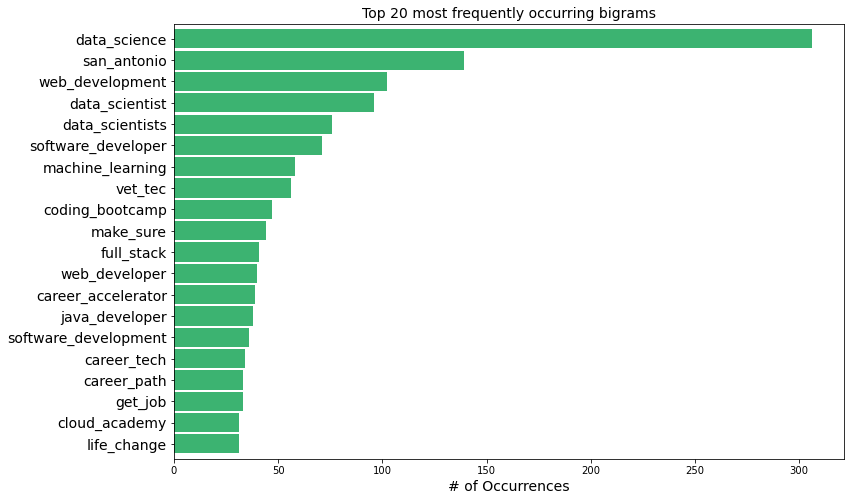

In [22]:
top_20_bis = bigram_freq.head(20)
top_20_bis.sort_values().plot.barh(color='mediumseagreen', 
                                     width=.9, 
                                     figsize=(12,8))
plt.title('Top 20 most frequently occurring bigrams', fontsize=14)
plt.xlabel('# of Occurrences', fontsize=14)
plt.yticks(fontsize=14)
plt.show()

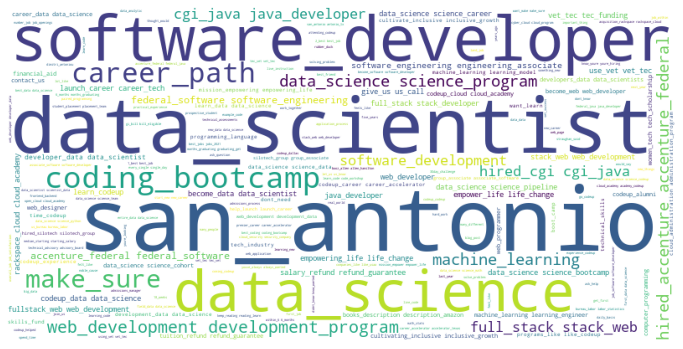

In [23]:
img = WordCloud(background_color='white', width=800, height=400).generate(' '.join(bigrams))
plt.figure(figsize=(12,8))
plt.imshow(img)
plt.axis('off')
plt.show()